# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [2]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

## Loading data

In [3]:
DATA_PATH = 'data/'

In [4]:
states = pd.read_csv(DATA_PATH + 'states.csv')

In [5]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data
Features are converted into appropriate format and redundant data is removed as well.  

Note that it is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [6]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [7]:
politics_06.sample(5).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
1040840,awesley,NaN,&gt; He argued the percentages changed \n\nBut...,2016-06-23 12:12:19,0,d4kodgy,4pbok8,d4klj32,1
161210,chevrolaycorveete64,NaN,he could have stopped after 'trump',2016-06-04 15:46:05,0,d3vsvpf,4mg8qx,4mg8qx,2
855163,Now_you_fucked_up,NaN,You sound like you're really looking to have a...,2016-06-18 04:28:10,0,d4dyti8,4ok8rq,d4dycxc,1
672420,Level_32_Mage,NaN,Turn back now!,2016-06-14 06:14:08,0,d48fmff,4nzbhv,d48b57c,1
459896,Anomaj,NaN,No point in talking about what if scenarios.,2016-06-09 18:13:10,0,d42lfn0,4nbw98,d42kqte,2


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [8]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index(drop=True)
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [9]:
politics.dtypes

author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [10]:
politics.describe()

,gilded,score
count,1.086033e+07,1.086033e+07
mean,3.835981e-04,6.766324e+00
std,2.441999e-02,5.706394e+01
min,0.000000e+00,-8.620000e+02
25%,0.000000e+00,1.000000e+00
50%,0.000000e+00,1.000000e+00
75%,0.000000e+00,4.000000e+00
max,1.400000e+01,1.901100e+04


In [11]:
politics.sample(5).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
1691144,scotchcleanscuts,NaN,&gt; The very idea let alone the reality that ...,2016-07-11 09:37:13,0,d57okqg,4s7e4c,d57oi58,1
10198273,AmbroseMalachai,NaN,I don't think that's true. I was a staunch Hil...,2016-11-20 11:59:09,0,da830lk,5dw0of,5dw0of,0
297815,escapefromelba,NaN,The State Department email system has been hac...,2016-06-07 10:36:49,0,d3za5tj,4mw2t6,d3z5s3h,1
9005951,itsjabo,NaN,It's clear that the Russians love trump,2016-11-09 01:54:16,0,d9s0uz9,5bxjb8,d9s0kz5,1
7818272,NWBoomer,NaN,White boomer here; sloppy journalism and crap ...,2016-10-23 15:49:16,0,d94bley,58y5tc,58y5tc,0


In [102]:
politics.shape

(10860326, 9)

Unfortunately, the dataset being too big to be dealt with efficiently locally, a decision was taken to have a second dataset with reduced size by sampling the original one so that further operations on it takes appropriate execution time.

In [190]:
politics_outliers = politics[(politics['score'] > 175) | (politics['score'] < -20)]
politics_sample = politics[(politics['score'] <= 175) & (politics['score'] >= -20)].sample(frac=0.01, random_state=23)

In [191]:
politics_outliers.shape

(102145, 9)

In [192]:
politics_sample.shape

(107582, 9)

In [193]:
politics_lite = pd.concat([politics_outliers, politics_sample]).reset_index(drop=True)
politics_lite.shape

(209727, 9)

In [194]:
politics_lite.sample(5).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
115790,robo23,NaN,Lock them up. \n\nAnd if you see something rea...,2016-10-15 14:04:17,0,d8t1wmw,57livv,d8sxtun,41
165210,alokinTESLA,NaN,The level of middle school that I was though d...,2016-10-17 19:45:42,0,d8w5xki,57xl4r,57xl4r,1
27838,ZeiglerJaguar,NaN,"As a journalism school graduate, the anti-medi...",2016-08-21 05:13:00,0,d6qaaha,4yssl1,d6q6etg,582
37331,DonsGuard,NaN,Of course she argued that Trump's supporters a...,2016-09-10 19:43:15,0,d7halfj,523jvv,d7ha49a,-22
108461,Markovski,NaN,"I mean I was asking a legitimate question, is ...",2016-07-23 14:54:12,0,d5nnkcd,4u5ztv,d5njsuu,19


In [195]:
politics_lite.to_parquet(DATA_PATH + 'politics_lite.parquet')

For further analysis, the set of commments whose author has a *flair* matching one of the 50 states of the United States of America is retrieved.

In [12]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'Josh Marshall, Talking Points Memo founder', 'West Virginia', 'Sen. Bob Casey (D-PA)', 'Michigan', 'Alabama', 'Louisiana', 'Harri Hursti, creator of the Hursti Hack', 'Russ Feingold (D-WI)', 'Northern Marianas', 'Georgia', 'Arizona', 'Hector Sigala, NWWA', 'Margaret Stock, AK senate candidate (I)', 'Popcorn', 'Alaska', 'Republic of Popcornia', 'Indiana', 'Libby Babbott-Klein, NWWA', 'Wisconsin', 'Nevada', 'Puerto Rico', 'Hawaii', 'Rhode Island', 'Pamela Smith, President of Verified Voting', 'Minnesota', 'Sr. Economic Analyst', 'Jim Burke (D-TX)', 'Gloria La Riva, 2016 Socialist candidate for president', 'Zephyr Teachout (D-NY)', 'Commissioner Walter Deleon (DC)', 'H.A. Goodman', 'Texas', 'Ohio', 'Chad Marlow, Advocacy and Policy Counsel at ACLU', 'Connecticut', 'Popcorn with extra salt.', 'Scott Wiener (D-CA)', 'AZ Healthy Working Families', 'Guam', 'District Of Columbia', 'Vermont', 'North Carolina', 'Montana', 'Utah', 'Kentucky', 'Alex Merced (L-NY)', 'Damien LaVera NWWA', 'Kansas'

In [13]:
state_full = set(np.array(states['State']))
abbreviation = set(np.array(states['Abbreviation']))
print(state_full)
print(len(state_full))

{'North Dakota', 'Ohio', 'Texas', 'Connecticut', 'Missouri', 'West Virginia', 'Nebraska', 'New Hampshire', 'Washington', 'Michigan', 'New Jersey', 'Wyoming', 'Alabama', 'Mississippi', 'South Carolina', 'Louisiana', 'Oklahoma', 'Florida', 'Delaware', 'Vermont', 'Georgia', 'Arizona', 'North Carolina', 'Montana', 'Maryland', 'Utah', 'Alaska', 'Kentucky', 'Virginia', 'Maine', 'Indiana', 'Iowa', 'Kansas', 'Wisconsin', 'New Mexico', 'Nevada', 'Colorado', 'Hawaii', 'Idaho', 'Pennsylvania', 'Rhode Island', 'Tennessee', 'Minnesota', 'California', 'Oregon', 'New York', 'South Dakota', 'Illinois', 'Massachusetts', 'Arkansas'}
50


In [14]:
flair_politics = politics[politics['author_flair_text'].isin(state_full) | politics['author_flair_text'].isin(abbreviation)]
state_list = list(set(flair_politics['author_flair_text']))
print(state_list)
len(state_list)

['North Dakota', 'Texas', 'Ohio', 'Connecticut', 'Missouri', 'West Virginia', 'Nebraska', 'Washington', 'New Hampshire', 'Michigan', 'New Jersey', 'Wyoming', 'Alabama', 'South Carolina', 'Mississippi', 'Louisiana', 'Oklahoma', 'Florida', 'Delaware', 'Vermont', 'Georgia', 'North Carolina', 'Arizona', 'Montana', 'Maryland', 'Utah', 'Alaska', 'Kentucky', 'Virginia', 'Maine', 'Indiana', 'Iowa', 'Kansas', 'Wisconsin', 'New Mexico', 'Nevada', 'Colorado', 'Idaho', 'Pennsylvania', 'Hawaii', 'Rhode Island', 'Tennessee', 'Minnesota', 'California', 'Oregon', 'New York', 'South Dakota', 'Illinois', 'Massachusetts', 'Arkansas']


50

In [15]:
print(flair_politics.shape)
flair_politics.sample(5).head()

(214934, 9)


,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6410440,Mind_Reader,New York,No problem :),2016-10-05 00:55:54,0,d8ecwne,55viu7,d8eceso,1
6850735,elbenji,Florida,The issue is they dont give a fuck about jihad...,2016-10-10 11:03:39,0,d8lpxaj,56qdxp,d8lmyh5,3
6758135,viccar0,Pennsylvania,This is....... amazing,2016-10-10 01:18:36,0,d8l84mj,56pbui,56pbui,1
6402944,DeanBlandino,Ohio,Pretty common for dems. Kerry was the same. Bi...,2016-10-04 22:09:33,0,d8e5z46,55u0y6,d8do656,3
6256228,sandernista_4_TRUMP,South Carolina,"What a brave thing for you to say, and it adds...",2016-10-02 06:32:55,0,d8aipm4,55gzpc,d8ail3b,-8


## Processing data

Below, you'll find a few methods doing natural language processing - using the NLTK library - over the body of the comments. They allow named entity retrieval, sentiment analysis and word frequency computation.

In [16]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    body = body.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops and len(word) > 1]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    """Classify the sentiment as either Positive, Neutral or Negative according to its numeric values."""
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"
    
def get_word_count(df, sentiment):
    """Get the word count of a given DataFrame using only comments matching the given sentiment. 
    sentiment can be 'Positive', 'Negative', 'Neutral' or 'None' in which case the word count is computed
    for the entire DataFrame."""
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

Below, an example to display these methods.

In [17]:
sample = politics.sample(1).copy()

sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
5338888,rndljfry,NaN,I've got a few people on Facebook who only pos...,2016-09-17 18:44:37,0,d7qtjjr,537f6j,d7qrxzu,9,"PERSON Kick Obama Out,ORGANIZATION Girl","0.5707,0.049,0.859,0.092","{'ive': 1, 'got': 1, 'people': 1, 'facebook': ...",Positive


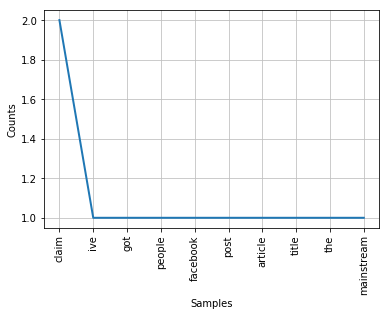

In [41]:
nltk.FreqDist(dict(sample.iloc[0]['wordcount'].most_common(10))).plot()


### What are the most used words in positive/negative comments?
Using the previously defined methods, it is now possible to observe which words come up the more often in comments classified as either positive or negative.  
As this part is ran locally, the previously generated dataset containing only comments whose author has a flair matching one of the states of the United States of America is used since it is relatively small.

In [19]:
sample_sorted_score = flair_politics.sample(10000).copy().sort_values(by=['score'], ascending=False)
sample_sorted_score['entity'] = sample_sorted_score['body'].apply(nlp_entity)
sample_sorted_score['sentiment'] = sample_sorted_score['body'].apply(nlp_sentiment)
sample_sorted_score['wordcount'] = sample_sorted_score['body'].apply(nlp_wordcount)
sample_sorted_score['label'] = sample_sorted_score['sentiment'].apply(sentiment_to_label)
sample_sorted_score.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
9970404,ZeiglerJaguar,Illinois,"At this point, I can't wait for him to actuall...",2016-11-17 01:19:04,0,da3l9gl,5dcw4i,da3knoj,2042,,"-0.5708,0.126,0.753,0.121","{'at': 1, 'point': 2, 'cant': 1, 'wait': 1, 'a...",Negative
7389099,DC25NYC,New York,Anddddd back to hating McCain.,2016-10-17 17:59:32,0,d8w0kmn,57yrdl,57yrdl,1743,"PERSON Anddddd,PERSON McCain","-0.5106,0.452,0.548,0.0","{'anddddd': 1, 'back': 1, 'hating': 1, 'mccain...",Negative
10186983,GucciNutz,New York,It's funny that intolerant people keep calling...,2016-11-20 03:29:07,1,da7rr0h,5dw0of,5dw0of,1493,GPE Edit,"0.7003,0.0,0.746,0.254","{'it': 1, 'funny': 1, 'intolerant': 3, 'people...",Positive
10806933,Predictor92,New York,I am going to put it like this. If Michigan wo...,2016-11-30 05:19:05,0,dalo7bc,5fnh1l,5fnh1l,1489,"PERSON Michigan,PERSON Lucas County,ORGANIZATI...","0.5423,0.064,0.799,0.137","{'going': 1, 'put': 1, 'like': 1, 'if': 1, 'mi...",Positive
7203081,Lynx_Rufus,Maine,Gloria Allred is the jurisprudence version of ...,2016-10-14 18:50:00,0,d8s45kh,57hya5,57hya5,1315,"GPE Gloria,ORGANIZATION Allred,PERSON Omar Lit...","-0.6597,0.144,0.856,0.0","{'gloria': 1, 'allred': 1, 'jurisprudence': 1,...",Negative


#### Word distribution of comments whose score is higher than a certain threshold

In [20]:
score_threshold = 50
high_score_comments = sample_sorted_score[sample_sorted_score['score'] > score_threshold].copy()

high_score_comments.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
9970404,ZeiglerJaguar,Illinois,"At this point, I can't wait for him to actuall...",2016-11-17 01:19:04,0,da3l9gl,5dcw4i,da3knoj,2042,,"-0.5708,0.126,0.753,0.121","{'at': 1, 'point': 2, 'cant': 1, 'wait': 1, 'a...",Negative
7389099,DC25NYC,New York,Anddddd back to hating McCain.,2016-10-17 17:59:32,0,d8w0kmn,57yrdl,57yrdl,1743,"PERSON Anddddd,PERSON McCain","-0.5106,0.452,0.548,0.0","{'anddddd': 1, 'back': 1, 'hating': 1, 'mccain...",Negative
10186983,GucciNutz,New York,It's funny that intolerant people keep calling...,2016-11-20 03:29:07,1,da7rr0h,5dw0of,5dw0of,1493,GPE Edit,"0.7003,0.0,0.746,0.254","{'it': 1, 'funny': 1, 'intolerant': 3, 'people...",Positive
10806933,Predictor92,New York,I am going to put it like this. If Michigan wo...,2016-11-30 05:19:05,0,dalo7bc,5fnh1l,5fnh1l,1489,"PERSON Michigan,PERSON Lucas County,ORGANIZATI...","0.5423,0.064,0.799,0.137","{'going': 1, 'put': 1, 'like': 1, 'if': 1, 'mi...",Positive
7203081,Lynx_Rufus,Maine,Gloria Allred is the jurisprudence version of ...,2016-10-14 18:50:00,0,d8s45kh,57hya5,57hya5,1315,"GPE Gloria,ORGANIZATION Allred,PERSON Omar Lit...","-0.6597,0.144,0.856,0.0","{'gloria': 1, 'allred': 1, 'jurisprudence': 1,...",Negative


In [21]:
word_positive_high_score = get_word_count(high_score_comments, 'Positive')
word_negative_high_score = get_word_count(high_score_comments, 'Negative')
word_count_high_score = get_word_count(high_score_comments, 'None')

The most common words in comments with a high score deemed positive.

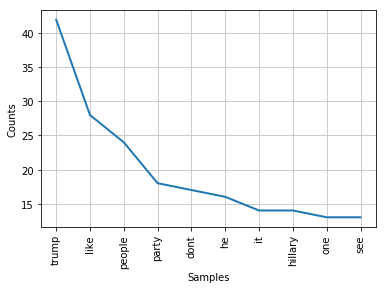

In [22]:
nltk.FreqDist(dict(word_positive_high_score.most_common(10))).plot()

The most common words in comments with a high score deemed negative.

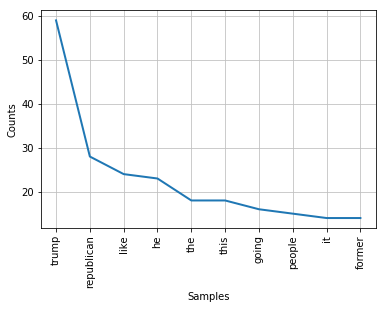

In [23]:
nltk.FreqDist(dict(word_negative_high_score.most_common(10))).plot()

The most common words in comments with a high score.

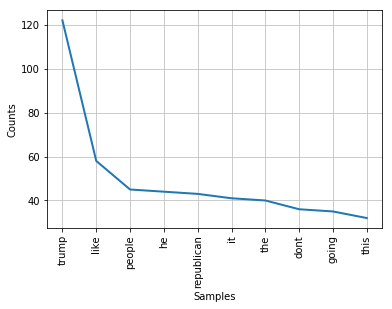

In [24]:
nltk.FreqDist(dict(word_count_high_score.most_common(10))).plot()

#### Word distribution of comments whose score is below 0

In [25]:
low_score_comments = sample_sorted_score[sample_sorted_score['score'] < 0].copy()

low_score_comments.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
10636209,drewiepoodle,California,"Soooooooo, nothing, i heard you the first time...",2016-11-27 16:26:10,0,dahos51,5f56jq,dahn79s,-1,GPE Soooooooo,"0.0,0.0,1.0,0.0","{'soooooooo': 1, 'nothing': 1, 'heard': 1, 'fi...",Neutral
6929600,giannini1222,California,"You may not like his political views, but he s...",2016-10-11 05:58:17,0,d8n00m6,56u63b,d8mus3o,-1,,"-0.3784,0.207,0.664,0.129","{'you': 1, 'may': 1, 'like': 1, 'political': 1...",Negative
6701193,santac311,Maryland,"That's right, you probably missed it and didn'...",2016-10-09 12:30:51,0,d8kdauc,56luzl,d8kd04q,-1,,"-0.296,0.136,0.864,0.0","{'thats': 1, 'right': 1, 'probably': 1, 'misse...",Negative
7478180,nophantomlimbs,Texas,"going off script you going to get in trouble, ...",2016-10-18 21:18:39,0,d8xtqin,585fan,d8xtmgf,-1,,"-0.4019,0.172,0.828,0.0","{'going': 2, 'script': 1, 'get': 1, 'trouble':...",Negative
6931780,truthhurts4444,New Hampshire,Can't wait to hear the political views of Taki...,2016-10-11 07:28:52,0,d8n26zk,56wwoi,d8n21to,-1,"PERSON Back,PERSON Brand New","0.0,0.0,1.0,0.0","{'cant': 1, 'wait': 1, 'hear': 1, 'political':...",Neutral


In [26]:
word_positive_low_score = get_word_count(low_score_comments, 'Positive')
word_negative_low_score = get_word_count(low_score_comments, 'Negative')
word_count_low_score = get_word_count(low_score_comments, 'None')

The most common words in comments with a score below 0 deemed positive.

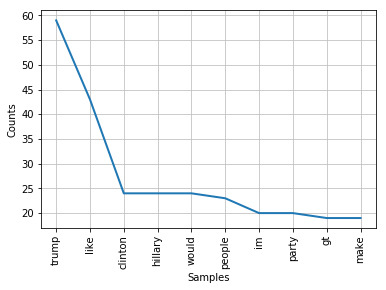

In [27]:
nltk.FreqDist(dict(word_positive_low_score.most_common(10))).plot()

The most common words in comments with a score below 0 deemed negative.

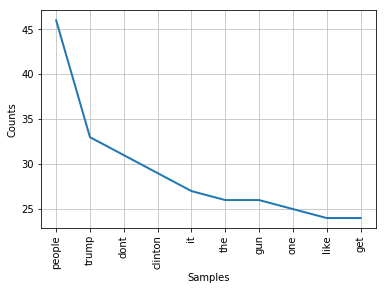

In [28]:
nltk.FreqDist(dict(word_negative_low_score.most_common(10))).plot()

The most common words in comments with a score below 0.

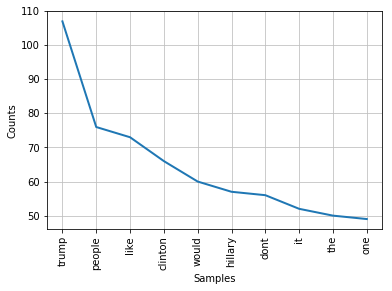

In [29]:
nltk.FreqDist(dict(word_count_low_score.most_common(10))).plot()

#### Comparing high and low score comments
By comparing word frequencies, words that appear only in low/high score comments can be retrieved, as well as words that appear in both type of comments. By low score comments, comments with a score below 0 is meant.

In [30]:
both = nltk.FreqDist()
good_only = nltk.FreqDist()
for word in word_count_high_score:
    if word in word_count_low_score:
        both[word] += word_count_high_score.get(word) + word_count_low_score.get(word)
    else:
        good_only[word] = word_count_high_score.get(word)
        
bad_only = nltk.FreqDist()
for word in word_count_low_score:
    if word not in word_count_high_score:
        bad_only[word] = word_count_low_score.get(word)

The most common words appearing in both low and high score comments.

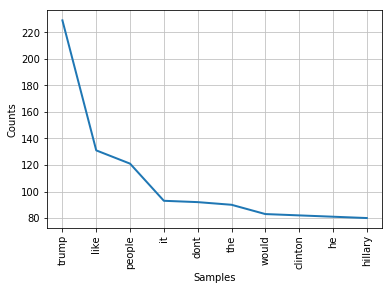

In [31]:
nltk.FreqDist(dict(both.most_common(10))).plot()

The most common words appearing in high score comments.

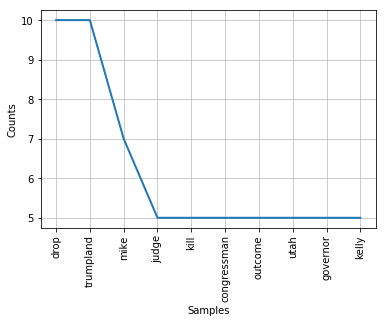

In [32]:
nltk.FreqDist(dict(good_only.most_common(10))).plot()

The most common words appearing in low score comments.

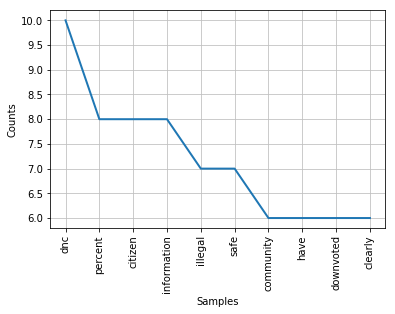

In [33]:
nltk.FreqDist(dict(bad_only.most_common(10))).plot()

## Entities

In [34]:
flair_politics['entity'] = flair_politics['body'].apply(nlp_entity)
flair_politics['sentiment'] = flair_politics['body'].apply(nlp_sentiment)
flair_politics['wordcount'] = flair_politics['body'].apply(nlp_wordcount)
flair_politics['label'] = flair_politics['sentiment'].apply(sentiment_to_label)

KeyboardInterrupt: 

In [1]:
flair_politics.to_parquet(DATA_PATH + 'flair_politics.parquet')

NameError: name 'flair_politics' is not defined

In [163]:
flair_politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'juno255': 1, 'thank': 1, 'participa...",Positive
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'alejandrolastname': 1, 'thank': 1, ...",Positive
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1,"ORGANIZATION ImNotJesus,PERSON Title,ORGANIZAT...","0.8738,0.0,0.883,0.117","{'hi': 1, 'imnotjesus': 1, 'thank': 1, 'partic...",Positive
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1,"PERSON Rehosted Content,GPE Video,ORGANIZATION...","0.9163,0.0,0.843,0.157","{'hi': 1, 'cmonshoe': 1, 'thank': 1, 'particip...",Positive
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'abourne': 1, 'thank': 1, 'participa...",Positive


In [169]:
#remplacé ancienne methode score par celle ci pour pas faire 2 loops
def get_score(row, candidate1, candidate2, out_states, score= False):
    current_state = row['author_flair_text']
    firstName1=candidate1[0]
    lastName1=candidate1[1]
    firstName2=candidate2[0]
    lastName2=candidate2[1]
    if firstName1 in row['entity'] or lastName1 in row['entity']:
        if row['label'] == 'Positive': 
            if score : 
                out_states.loc[current_state, 'score_'+lastName1] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] += 1
        elif row['label'] == 'Negative':
            if score : 
                out_states.loc[current_state, 'score_'+lastName1] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] -= 1
    
    if firstName2 in row['entity'] or lastName2 in row['entity']:
        if row['label'] == 'Positive':          
            if score : 
                out_states.loc[current_state, 'score_'+lastName2] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] += 1
        elif row['label'] == 'Negative':
            if score : 
                out_states.loc[current_state, 'score_'+lastName2] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] -= 1

In [170]:
def comp_winner(state_df):
    final_score = []
    for state in state_df.index :
        if (state_df.loc[state, 'score_Clinton']>state_df.loc[state, 'score_Trump']):
            #0 if Clinton wins
            final_score.append(0)
        else :
            #1 if Trump wins
            final_score.append(1)
    return final_score

## Scores do not count : 

In [171]:
state_df = states.copy()
state_df.set_index('State', inplace=True)
state_df.head()

,Abbreviation
State,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


In [172]:
state_df['score_Trump'] = 0
state_df['score_Clinton'] = 0
candidate1 = ['Donald', 'Trump']
candidate2 = ['Hillary', 'Clinton']

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df, axis=1)
state_df['Winner'] = comp_winner(state_df)
state_df.reset_index(inplace = True)
state_df.set_index('Abbreviation', inplace=True)

state_df.head()

,State,score_Trump,score_Clinton,Winner
Abbreviation,,,,
AL,Alabama,9,16,0
AK,Alaska,-26,2,0
AZ,Arizona,-16,-25,1
AR,Arkansas,7,1,1
CA,California,102,189,0


In [143]:
def us_election_colors(state_df, state):
    """Maps Clinton wins to blue and Trump wins to red."""
    clinton_win = state_df.loc[state, 'Winner'] == 0
    if clinton_win:
        return '#0000ff'
    else:
        return '#ff0000'

In [167]:
state_geo_path = DATA_PATH + r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

results_map = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)

results_map

In [168]:
results_map.save('US_Election_Prediction_2016.html')

## Scores count :

In [176]:
state_df2 = states.copy()
state_df2.set_index('State', inplace=True)
state_df2['score_Trump'] = 0
state_df2['score_Clinton'] = 0

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df2, score=True, axis=1)
state_df2['Winner'] = comp_winner(state_df2)
state_df2.reset_index(inplace = True)
state_df2.set_index('Abbreviation', inplace=True)

state_df2.head()

,State,score_Trump,score_Clinton,Winner
Abbreviation,,,,
AL,Alabama,-557,591,0
AK,Alaska,747,523,1
AZ,Arizona,-151,230,0
AR,Arkansas,-980,-37,0
CA,California,4939,4770,1


In [177]:
results_map_score = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df2, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map_score)

results_map_score

In [178]:
results_map_score.save('US_Election_Pred_Using_Scores_2016.html')

## Visualizing data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [52]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

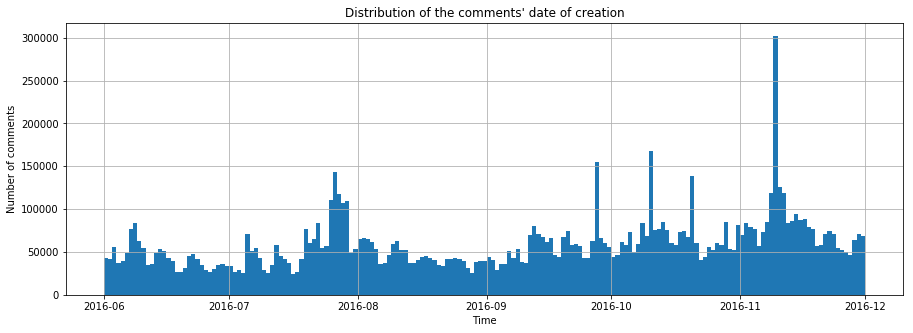

In [53]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title("Distribution of the comments' date of creation")
plt.show()

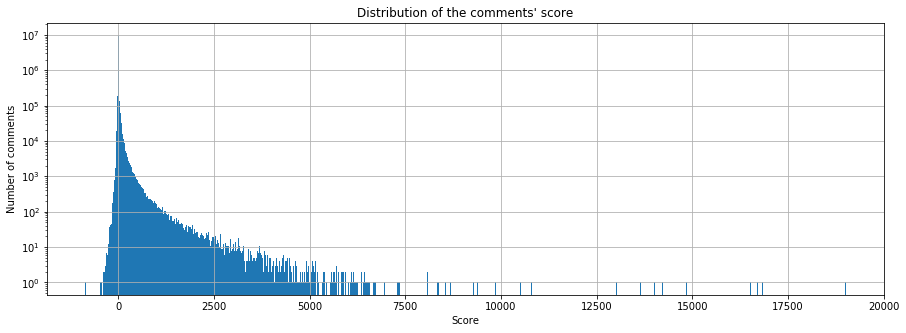

In [54]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['score'], bins=1000, log=True)
plt.ylabel('Number of comments')
plt.xlabel('Score')
plt.title("Distribution of the comments' score")
plt.show()